## Statistical Analysis

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from scipy.stats import ttest_ind, mannwhitneyu
from matplotlib import pyplot as plt
from statsmodels.stats import proportion
from statsmodels.stats.power import TTestIndPower

In [2]:
# set global parameters
sns.set(style='darkgrid') 
warnings.filterwarnings('ignore')

In [3]:
# read csv file and print our 5 rows
df = pd.read_csv('C:/GeekBrainsPractice/11_AB_testing/9/homework/cookie_cats.csv')
display(df.head(5))

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [4]:
# show general info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [5]:
# show stats
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [6]:
# show categories
df['version'].unique()

array(['gate_30', 'gate_40'], dtype=object)

In [7]:
# count duplicate values in userid column
len(df['userid']) - len(df['userid'].drop_duplicates())

0

In [8]:
# size of control and treatment data
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [13]:
# percantage of two groups
retention_df = df[['retention_1', 'retention_7']].mean() * 100
print(f'1-day retention ratio:  {round(retention_df[0], 2)}% \
      \n7-days retention ratio: {round(retention_df[1], 2)}%')

1-day retention ratio:  44.52%       
7-days retention ratio: 18.61%


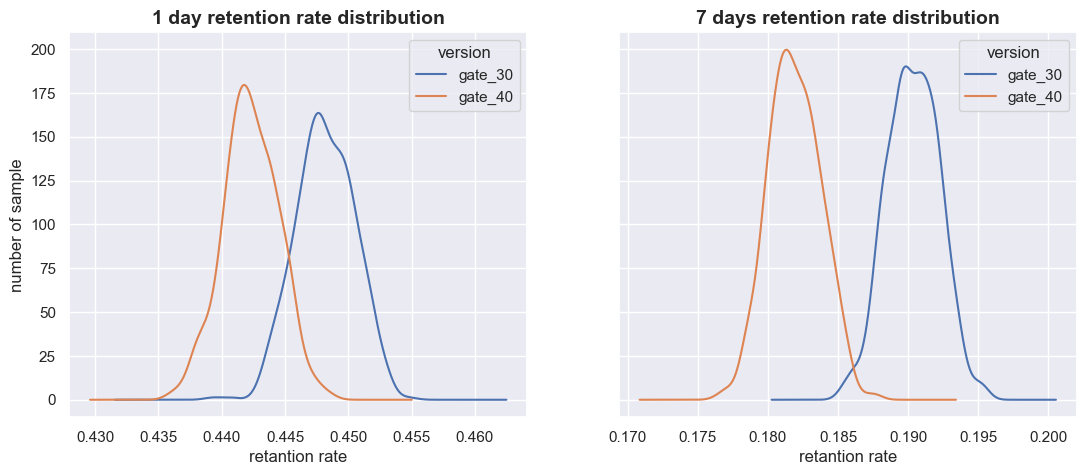

In [11]:
# create a list with bootstrapped means for each A/B group
boot_1d = []
boot_7d = []

for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# transform the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel('retantion rate', size=12)
ax1.set_ylabel('number of sample', size=12)
ax1.set_title('1 day retention rate distribution', fontweight='bold', size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel('retantion rate', size=12)
ax2.set_title('7 days retention rate distribution', fontweight='bold', size=14)
plt.show()

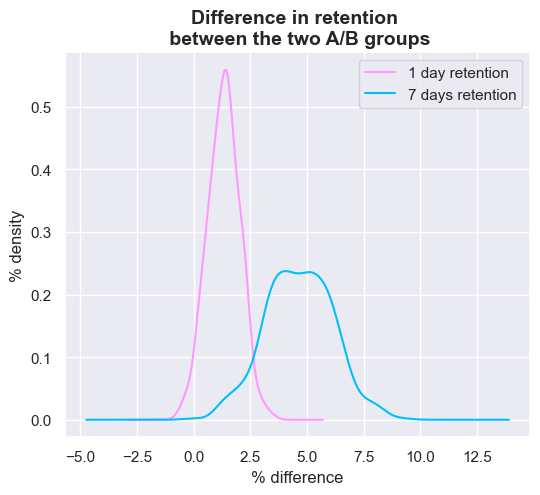

In [12]:
# add a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# plot the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1, figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c='#ff99ff', label = '1 day retention')
boot_7d['diff'].plot.kde(ax=ax1, c='#00bfff', label = '7 days retention')
ax1.set_xlabel('% difference', size=12)
ax1.set_ylabel('% density', size=12)
ax1.set_title('Difference in retention \n between the two A/B groups', fontweight='bold', size=14)
plt.legend()
plt.show()

### 1 day retention

In [34]:
# calculate coefficients
n1_1d, n2_1d = df['version'].value_counts()
k1_1d, k2_1d = df.query('retention_1 == 1').version.value_counts()

In [35]:
# Chi-squared test
# examine the differences between categorical variables
proportion.proportions_chisquare(np.array([k1_1d, k2_1d]), np.array([n1_1d, n2_1d]))

(3.182963657512031,
 0.07440965529692188,
 (array([[20119., 25370.],
         [20034., 24666.]]),
  array([[20252.13514952, 25236.86485048],
         [19900.86485048, 24799.13514952]])))

There is no statistical significance between samples due to pvalue=0.07 (>0.05)

In [36]:
# Z-test
# examine the differences between categorical variables
proportion.proportions_ztest(np.array([k1_1d, k2_1d]), np.array([n1_1d, n2_1d]))

(-1.7840862247974725, 0.07440965529691913)

There is no statistical significance between samples due to pvalue=0.07 (>0.05)

### 7 day retention

In [37]:
# calculate coefficients
n1_7d, n2_7d = df['version'].value_counts()
k1_7d, k2_7d = df.query('retention_7 == 1').version.value_counts()

In [38]:
# Chi-squared test
# examine the differences between categorical variables
proportion.proportions_chisquare(np.array([k1_7d, k2_7d]), np.array([n1_7d, n2_7d]))

(0.42508609916171525,
 0.5144100282874547,
 (array([[ 8502., 36987.],
         [ 8279., 36421.]]),
  array([[ 8463.90257127, 37025.09742873],
         [ 8317.09742873, 36382.90257127]])))

There is no statistical significance between samples due to pvalue=0.51 (>0.05)

In [39]:
# Z-test
# examine the differences between categorical variables
proportion.proportions_ztest(np.array([k1_7d, k2_7d]), np.array([n1_7d, n2_7d]))

(0.6519862722187609, 0.5144100282874542)

There is no statistical significance between samples due to pvalue=0.51 (>0.05)